<a href="https://colab.research.google.com/github/chminPark/ml-python/blob/master/%5B%EC%A1%B0%EA%B5%90%EC%9A%A9%5D%EC%8B%A4%EC%8A%B53%EC%9D%BC%EC%B0%A8_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os
import numpy as np 
import random
import time 
import os

torch.backends.cudnn.deterministic = True # Use cudnn as deterministic mode for reproducibility
torch.backends.cudnn.benchmark = False

# CIFAR-10 데이터를 이용한다. 

In [ ]:
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4), # Random Crop: Randomly crop the part of the large image and utilize it as an augmented data 
        transforms.RandomHorizontalFlip(), # Random Horizontal Flip: Randomly flip the image and utilize it as an augmented data
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]), # Normalize the data using the given mean and standard deviation
        ])

#Apply data preprocessing for test set
transform_test = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]),
        ]) 

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)  

Files already downloaded and verified
Files already downloaded and verified


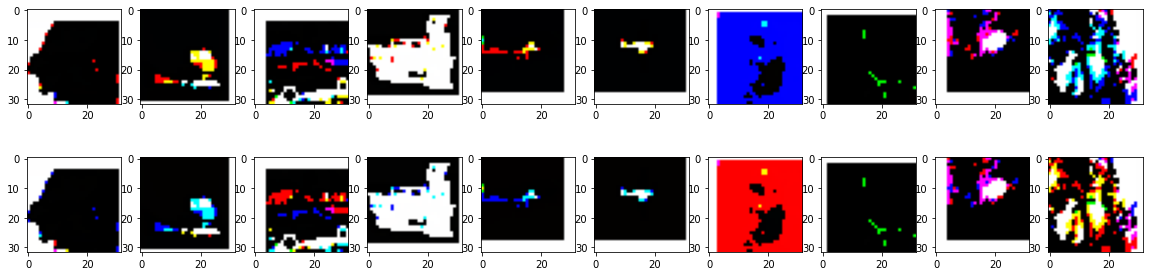

In [ ]:
# Cifar 데이터는 어떻게 생겼을까?
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

idxs = np.random.choice(len(train_dataset), 10, replace=False)

plt.figure(figsize=(20, 5))
for i, idx in enumerate(idxs):

  #### 실습 : Index로 데이터 확인
  #### 1) Tensor to Numpy 2) BGR to RGB
  image, target =  train_dataset[idx]

  image = image.permute(1,2,0).float().numpy()
  image_converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #########################################

  plt.subplot(2, 10, i+1)
  plt.imshow(image.astype(np.uint8))
  plt.subplot(2, 10, i+11)
  plt.imshow(image_converted.astype(np.uint8))


# ResNet의 Bottlenect 구조

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fcjoceg%2Fbtq0ulXxaaM%2FdkAS3aQHHg6BU4ReLgxsFk%2Fimg.png" height="300px" width="700px">



In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    r"""
    3x3 convolution with padding
    - in_planes: in_channels
    - out_channels: out_channels
    - bias=False: BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정.
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        r"""
         - inplanes: input channel size
         - planes: output channel size
         - groups, base_width: ResNext나 Wide ResNet의 경우 사용
        """
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
            
        # Basic Block의 구조
        self.conv1 = conv3x3(inplanes, planes, stride)  # conv1에서 downsample
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        # short connection
        if self.downsample is not None:
            identity = self.downsample(x)
            
        # identity mapping시 identity mapping후 ReLU를 적용합니다.
        # 그 이유는, ReLU를 통과하면 양의 값만 남기 때문에 Residual의 의미가 제대로 유지되지 않기 때문입니다.
        out += identity
        out = self.relu(out)

        return out

In [ ]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4 # 블록 내에서 차원을 증가시키는 3번째 conv layer에서의 확장계수
    
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # ResNext나 WideResNet의 경우 사용
        width = int(planes * (base_width / 64.)) * groups
        
        # 실습 : Bottleneck Block의 구조를 구현해 봅니다. 
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation) # conv2에서 downsample
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        # 실습 : Bottleneck Block의 구조를 구현해 봅니다. 
        identity = x
        # 1x1 convolution layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 3x3 convolution layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # 1x1 convolution layer
        out = self.conv3(out)
        out = self.bn3(out)
        # skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        # default values
        self.inplanes = 64 # input feature map
        self.dilation = 1
        # stride를 dilation으로 대체할지 선택
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        
        r"""
        - 처음 입력에 적용되는 self.conv1과 self.bn1, self.relu는 모든 ResNet에서 동일 
        - 3: 입력으로 RGB 이미지를 사용하기 때문에 convolution layer에 들어오는 input의 channel 수는 3
        """
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        r"""
        - 아래부터 block 형태와 갯수가 ResNet층마다 변화
        - self.layer1 ~ 4: 필터의 개수는 각 block들을 거치면서 증가(64->128->256->512)
        - self.avgpool: 모든 block을 거친 후에는 Adaptive AvgPool2d를 적용하여 (n, 512, 1, 1)의 텐서로
        - self.fc: 이후 fc layer를 연결
        """
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, # 여기서부터 downsampling적용
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        r"""
        convolution layer 생성 함수
        - block: block종류 지정
        - planes: feature map size (input shape)
        - blocks: layers[0]와 같이, 해당 블록이 몇개 생성돼야하는지, 블록의 갯수 (layer 반복해서 쌓는 개수)
        - stride와 dilate은 고정
        """
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        
        # the number of filters is doubled: self.inplanes와 planes 사이즈를 맞춰주기 위한 projection shortcut
        # the feature map size is halved: stride=2로 downsampling
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        # 블록 내 시작 layer, downsampling 필요
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion # inplanes 업데이트
        # 동일 블록 반복
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [ ]:
def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(Bottleneck, [3,4,6,3])

def resnet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])

def resnet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [ ]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# 학습함수를 선언하고 학습을 수행한다

In [ ]:
def train(model, data_loader, criterion, optimizer, n_epoch, device):
  ### 실습 : 학습 중임을 알림
  model.train() ###
  for epoch in range(n_epoch):
    running_loss = 0
    for i, (images, labels) in enumerate(data_loader):
      ### 실습 : 데이터를 GPU로 할당
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if (i + 1) % 100 == 0:
        print('iteration: [{}/{}]'.format(i + 1, len(data_loader)))
          
    print('Epoch {}, loss = {:.3f}'.format(epoch + 1, running_loss/len(data_loader)))

In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)

##### Adam 최적화 모델을 할당한다
optimizer = optim.Adam(params=model.parameters())

train(model, train_loader, criterion, optimizer, n_epoch=10, device=device)

iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 1, loss = 1.897
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 2, loss = 1.685
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 3, loss = 1.500
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 4, loss = 1.751


# 평가 함수를 구성하고 평가 정확도를 확인한다

In [ ]:
def eval(model, data_loader):
  #### 실습 : 평가를 위해서는 eval()을 선언
  model.eval()
  total = 0
  correct = 0
  #### 실습 : Gradient를 타지 않아야 한다
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
      
  print('Test Accuracy: {}%'.format(accuracy))

In [ ]:
eval(model, test_loader)

Test Accuracy: 78.01%
